Here, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

#### Import Keras and other necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.metrics import precision_recall_curve

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["RETAINED", "LEFT"]

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
#Fpath = 'C:/Users/sushant_singh01/Documents/Python Scripts/Data/'
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Exploration

In [3]:
df.shape

(7043, 21)

In [4]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [5]:
df.isnull().values.any()

False

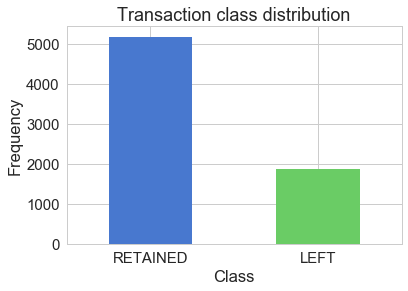

In [6]:
count_classes = pd.value_counts(df['Churn'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [7]:
left = df[df.Churn == 'Yes']
retained = df[df.Churn == 'No']

In [8]:
left.shape

(1869, 21)

In [9]:
retained.shape

(5174, 21)

Doesn't seem like the time of transaction really matters.

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle: https://www.youtube.com/embed/FzS3tMl4Nsc

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [10]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

In [11]:
data = df.drop(['customerID'], axis=1)
#data['Amount'] = StandardScaler().fit_tracategorical_features = df.select_dtypes(include=['object']).columns.tolist()nsform(data['Amount'].values.reshape(-1, 1))

In [12]:
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
continuous_features  = data.select_dtypes(include=['number']).columns.tolist()

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [13]:
#Convert categorical features to numerical
def encoding(df,categorical_features):
    
    df_cat = df[categorical_features]
    #By defaault, convert all the categories to numerical forms using Label encoder
    le = {}
    for i in range(len(df_cat.columns.tolist())):
        le[i] = LabelEncoder()
        df_cat.iloc[:,i] = le[i].fit_transform(df_cat.iloc[:,i].astype(str))

    return df_cat

In [14]:
encoded_data  = encoding(data,categorical_features)
data          = pd.concat([data[continuous_features],encoded_data],axis=1)
print('Encoded data looks like this: \n',data.head())

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Encoded data looks like this: 
    tenure  MonthlyCharges  gender  SeniorCitizen  Partner  Dependents  \
0       1           29.85       0              0        1           0   
1      34           56.95       1              0        0           0   
2       2           53.85       1              0        0           0   
3      45           42.30       1              0        0           0   
4       2           70.70       0              0        0           0   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0             0              1                0               0             2   
1             1              0                0               2             0   
2             1              0                0               2             2   
3             0              1                0               2             0   
4             1              0                1               0             0   

   DeviceProtection  TechSupport  Streamin

In [15]:
# Here the stratified shuffle split is done
X = data.iloc[:,:-1]
Y = data['Churn']
# have used 50 splits and test data proportion equal to 0.2
sss= StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=RANDOM_SEED)
# equating the index of all the shuffled index to the data.
for train_index, test_index in sss.split(X, Y):                           
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]            
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5634, 19) (5634,)
(1409, 19) (1409,)


In [17]:
print (np.count_nonzero(y_train))
print (np.count_nonzero(y_test))

1495
374


In [18]:
#Applying Standard Scaler to bring all the train, validation & test input atrributes under single scale
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [19]:
#Concatenate to use only normal cases from train set others into test set
train_set=np.concatenate((X_train, np.reshape(np.ravel(y_train), (-1,1))), axis=1)
test_set=np.concatenate((X_test, np.reshape(np.ravel(y_test), (-1,1))), axis=1)

In [20]:
train_set[train_set[:,19]==1, 19:20].shape

(1495, 1)

In [21]:
print(train_set.shape)
print(test_set.shape)

(5634, 20)
(1409, 20)


In [22]:
#Removing fraud cases from train set and adding them to test set
temp_fraud_set = train_set[train_set[:,19]==1]
train_set = train_set[train_set[:,19]==0]
test_set = np.concatenate((test_set, temp_fraud_set), axis=0)

# just randomly shuffle the test after adding fraud cases from train set
#np.random.shuffle(train_set)
np.random.shuffle(test_set)

print(train_set.shape)
print(test_set.shape)
print(temp_fraud_set.shape)

(4139, 20)
(2904, 20)
(1495, 20)


In [23]:
#Split train/test & label data
X_train, y_train = train_set[:,0:19], train_set[:,19:20]          
X_test, y_test = test_set[:,0:19], test_set[:,19:20] 

In [87]:
train_set[:,19:20] 

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [531]:
#Remove target column (Class) from normal train set
#X_train = X_train[X_train[:,29]==0,0:29]
#X_train = X_train.drop(['Class'], axis=1)

In [532]:
#We are not going to use y_train in our model so don't worry about removing the fraud cases from here.
#X_train.shape, y_train.shape

In [44]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4139, 19) (4139, 1)
(2904, 19) (2904, 1)


In [45]:
print (np.count_nonzero(y_train))
print (np.count_nonzero(y_test))

0
1869


# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [24]:
input_dim = X_train.shape[1]
#encoding_dim = int(input_dim/2)
encoding_dim = 

In [40]:
input_layer = Input(shape=(input_dim, ))

#encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l2(1e-3))(input_layer)
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
#encoder = Dropout(0.3)(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

#encoder = Dense(encoding_dim, activation="relu")(input_layer)       # encoding layer which uses relu as activation function
#encoder = Dense(int(encoding_dim/2), activation="sigmoid")(encoder) # encoding layer which uses sigmoid as activation function
#encoder=  Dense(int(encoding_dim/2), activation="tanh")(encoder)    # encoding layer which uses tanh as activation function
#decoder = Dense(int(encoding_dim/2), activation='relu')(encoder)    # decoding layer which uses relu as activation function
#decoder = Dense(int(encoding_dim/2), activation="sigmoid")(encoder) # decoding layer which uses sigmoid as activation function
#decoder = Dense(input_dim, activation='tanh')(decoder)              # decoding layer which uses tanh as activation function

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [41]:
nb_epoch =150
batch_size = 32

autoencoder.compile(optimizer='adam 
                    loss='mean_absolute_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="CCmodel.h5",
                               verbose=0,
                               save_best_only=True)
#tensorboard = TensorBoard(log_dir='C:/tmp/Anamoly/CC/',
#                          histogram_freq=0,
#                          write_graph=True)
                          #write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 4139 samples, validate on 2904 samples
Epoch 1/150
4139/4139 [==============================] - 2s 439us/step - loss: 0.8812 - acc: 0.0541 - val_loss: 0.8885 - val_acc: 0.0255
Epoch 2/150
4139/4139 [==============================] - 1s 137us/step - loss: 0.8772 - acc: 0.0870 - val_loss: 0.8869 - val_acc: 0.0334
Epoch 3/150
4139/4139 [==============================] - 1s 134us/step - loss: 0.8748 - acc: 0.1319 - val_loss: 0.8861 - val_acc: 0.0455
Epoch 4/150
4139/4139 [==============================] - 1s 171us/step - loss: 0.8729 - acc: 0.1723 - val_loss: 0.8853 - val_acc: 0.0523
Epoch 5/150
4139/4139 [==============================] - ETA: 0s - loss: 0.8708 - acc: 0.199 - 1s 196us/step - loss: 0.8709 - acc: 0.1981 - val_loss: 0.8842 - val_acc: 0.0572
Epoch 6/150
4139/4139 [==============================] - 1s 221us/step - loss: 0.8686 - acc: 0.2073 - val_loss: 0.8827 - val_acc: 0.0579
Epoch 7/150
4139/4139 [==============================] - 1s 185us/step - loss: 0.8658 - acc:

Epoch 60/150
4139/4139 [==============================] - 1s 206us/step - loss: 0.8209 - acc: 0.1766 - val_loss: 0.8508 - val_acc: 0.0368
Epoch 61/150
4139/4139 [==============================] - 1s 229us/step - loss: 0.8207 - acc: 0.1771 - val_loss: 0.8507 - val_acc: 0.0368
Epoch 62/150
4139/4139 [==============================] - 1s 182us/step - loss: 0.8204 - acc: 0.1769 - val_loss: 0.8505 - val_acc: 0.0372
Epoch 63/150
4139/4139 [==============================] - 1s 237us/step - loss: 0.8202 - acc: 0.1776 - val_loss: 0.8504 - val_acc: 0.0372
Epoch 64/150
4139/4139 [==============================] - 1s 178us/step - loss: 0.8200 - acc: 0.1771 - val_loss: 0.8502 - val_acc: 0.0382
Epoch 65/150
4139/4139 [==============================] - 1s 142us/step - loss: 0.8197 - acc: 0.1778 - val_loss: 0.8500 - val_acc: 0.0372
Epoch 66/150
4139/4139 [==============================] - 1s 130us/step - loss: 0.8195 - acc: 0.1773 - val_loss: 0.8499 - val_acc: 0.0375
Epoch 67/150
4139/4139 [==========

In [ ]:
autoencoder = load_model('CCmodel.h5')

# Evaluation

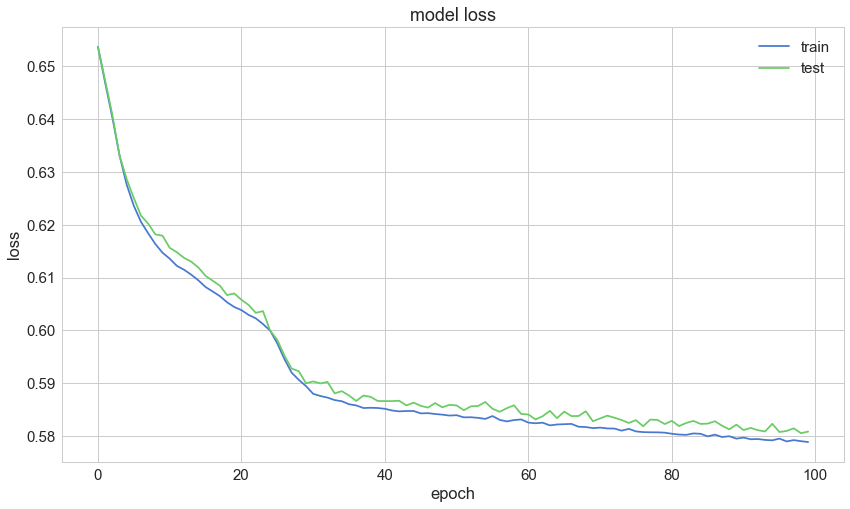

In [97]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [98]:
predictions = autoencoder.predict(X_test)

In [1]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': np.ravel(y_test)})

NameError: name 'np' is not defined

In [2]:
error_df.head(20)

NameError: name 'error_df' is not defined

In [57]:
error_df.describe()

reconstruction_error   true_class
count           2904.000000  2904.000000
mean               0.744927     0.643595
std                0.273214     0.479019
min                0.033249     0.000000
25%                0.577892     0.000000
50%                0.701421     1.000000
75%                0.850730     1.000000
max                1.865702     1.000000

## Reconstruction error without fraud

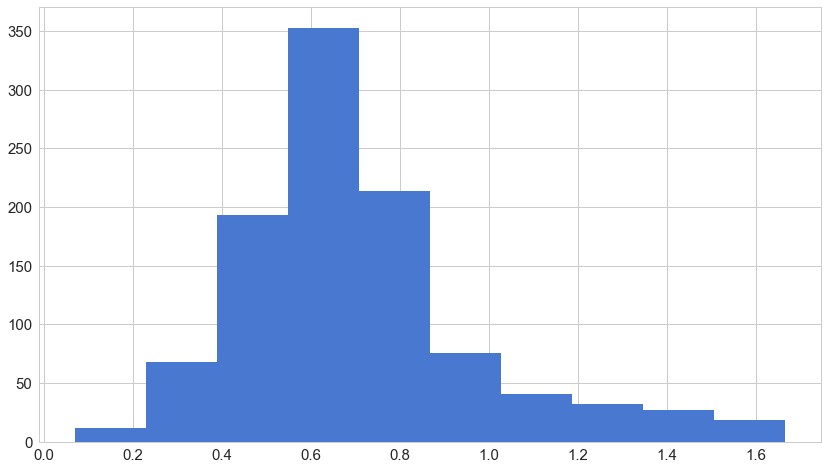

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

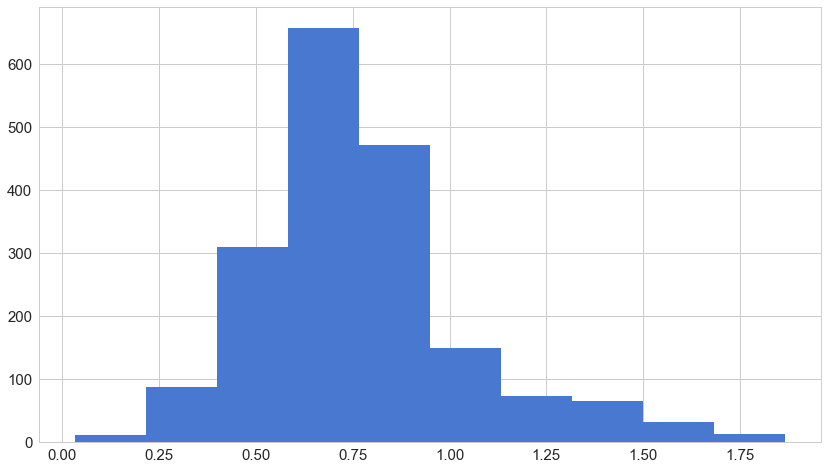

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

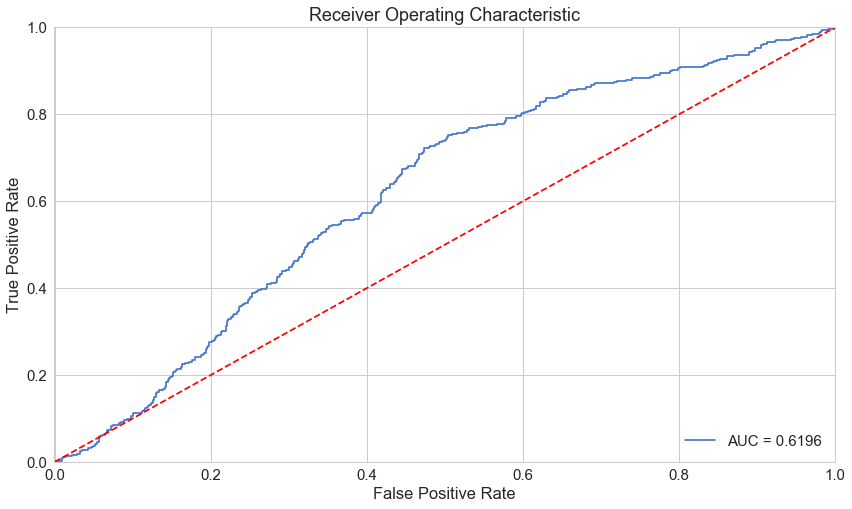

In [101]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

## Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

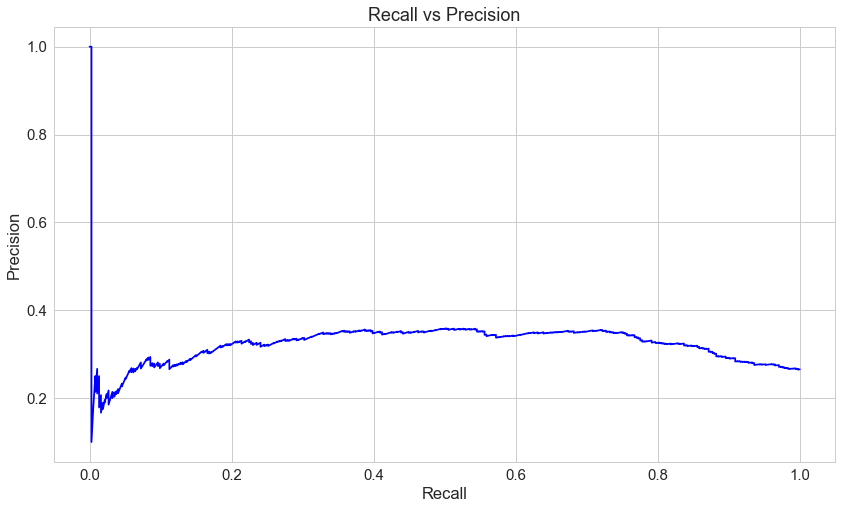

In [102]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In [103]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

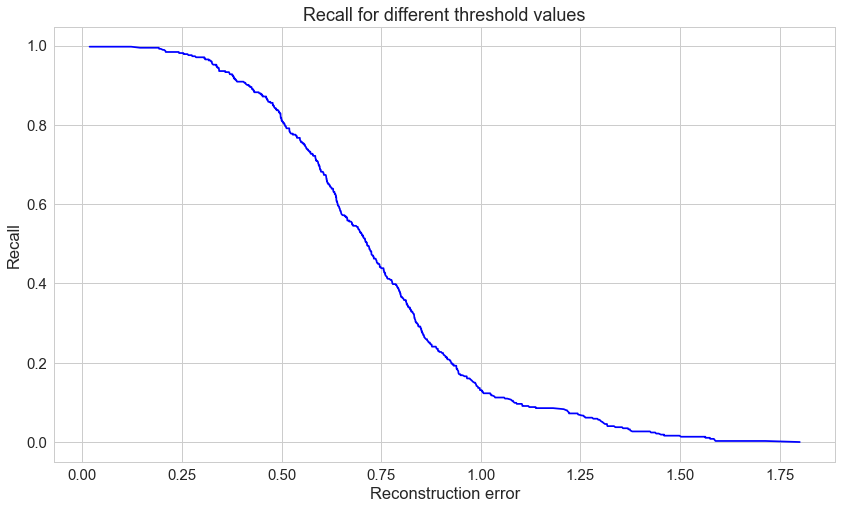

In [104]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

In [105]:
# this function returns a plot of Recall vs threshold/ Precision vs threshold with the point of intersection of two curves
def reconstruction(X_test, y_test):
    predictions = autoencoder.predict(X_test)          # predicting using the X_test
    mse = np.mean(np.power(X_test - predictions, 2), axis=1) # finding the mse value
    error_df = pd.DataFrame({'reconstruction_error': mse,    # making a dataframe with mse and y_test columns 
                        'true_class': y_test})
    precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error) # finding the precision, recall and threshold using  precision_recall_curve function
    plt.plot(th, precision[1:], 'b', label='Precision curve') # ploting the curve for Precision  
    plt.plot(th, recall[1:], 'r', label='Recall curve')       # plotting the curve for recall
    plt.title('Recall vs threshold/ Precision vs threshold ') # setting the title
    plt.xlabel('threshold')                                   # setting the x-label
    plt.ylabel('Precision/ Recall')                           # setting the y-label
    plt.legend()                                              # setting the legend
    
    idx = np.argwhere(np.diff((precision[1:] - recall[1:]) == 0))      # finding the index of the point of intersection of both the curves
    plt.plot(th[idx], precision[1:][idx],"yo", label = 'Intersection') # making a yellow dot on the point of intersection
    plt.show()                                                         
    return(th[idx], precision[1:][idx])

In [65]:
reconstruction(X_test, np.ravel(y_test))

(array([[0.63074474],
        [0.63097388]]), array([[0.69090909],
        [0.69127876]]))

Here, the intersection points doesn't really help to decide a good threshold but we can try value < 3.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [106]:
threshold = 0.65

And see how well we're dividing the two types of transactions:

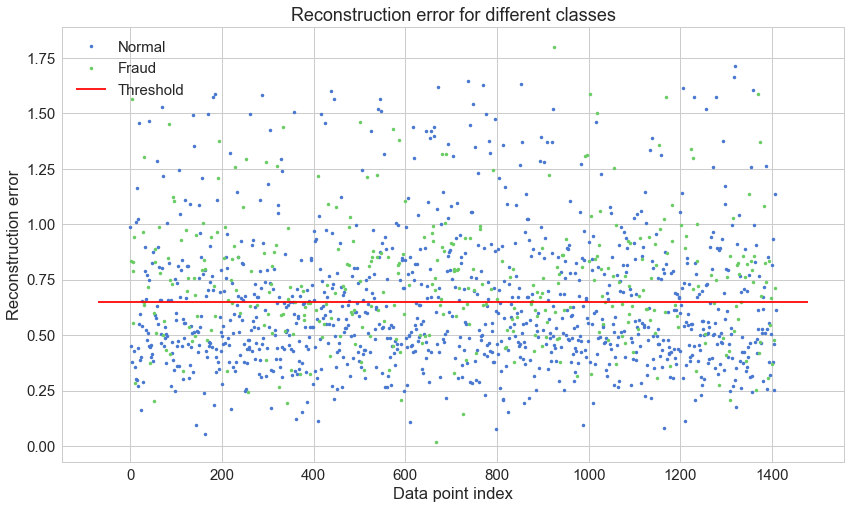

In [107]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

In [108]:
error_df.reconstruction_error.values[0]

0.9859507039886954

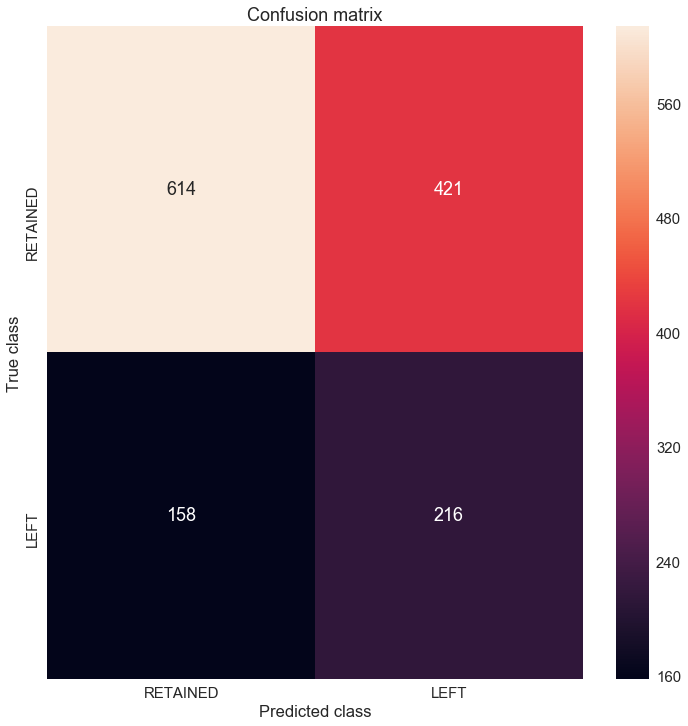

In [109]:
reclist=error_df.reconstruction_error.values
y_pred=reclist
for i in range(len(reclist)):
    if reclist[i] >= threshold:
        y_pred[i]=1
    else:
        y_pred[i]=0
        
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [110]:
conf_matrix

array([[614, 421],
       [158, 216]], dtype=int64)

In [111]:
X_test.shape

(1409, 19)

In [112]:
true_pos = np.diag(conf_matrix)
#false_pos = np.sum(conf_matrix, axis=0) - true_pos
#false_neg = np.sum(conf_matrix, axis=1) - true_pos

#precision = np.sum(true_pos / (true_pos+false_pos))
#recall = np.sum(true_pos / (true_pos + false_neg))

#precision = np.sum(true_pos / np.sum(conf_matrix, axis=0))
#recall = np.sum(true_pos / np.sum(conf_matrix, axis=1))

recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0)
                 
print ("Precision: ", precision, ";", "Recall: ", recall)

Precision:  [0.79533679 0.33908948] ; Recall:  [0.59323671 0.57754011]


In [580]:
print (classification_report(error_df.true_class, y_pred, target_names=['class 0','class 1']))
acc = accuracy_score(error_df.true_class, y_pred)
Accuracy = acc*100
print('Accuracy =',Accuracy)

             precision    recall  f1-score   support

    class 0       1.00      0.98      0.99     56864
    class 1       0.28      0.82      0.42       492

avg / total       0.99      0.98      0.99     57356

Accuracy = 98.06820559313759


In [85]:
#print('Total no. of Frauds in train data: ', y_train.value_counts()[1], 'out of ', y_train.count())
print('Total no. of Frauds in train data: ', np.count_nonzero(y_train), 'out of ', y_train.shape[0])
#print('Total no. of Frauds in test data: ', y_test.value_counts()[1], 'out of ', y_test.count())
print('Total no. of Frauds in test data: ', np.count_nonzero(y_test), 'out of ', y_test.shape[0])

Total no. of Frauds in train data:  0 out of  4139
Total no. of Frauds in test data:  1869 out of  2904


Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

# Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.